In [ ]:
# I love Google Colab

In [ ]:
# Shared functions/things
import numpy as np
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint

def create_training_data(parent,x):
	l=[]
	folder_name=parent+str(x)
	for i in os.listdir(folder_name):
		file_name=folder_name+"/"+i
		temp=x.split("-")
		valid_age=-1
		valid1=["0","4","8","15","25","38","48","60"]
		for i in range(len(valid1)):
			if valid1[i]==temp[0]:
				valid_age=i

		# Using 0 to read image in grayscale mode
		# img = cv2.imread(file_name,0)
		img = cv2.imread(file_name)
		# print(img.shape)
		# img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
		l.append([np.array(img),valid_age])
	
	return l

def get_exact1off_acc(test_X,test_Y,Model):
  result = Model.predict_classes(test_X)
  correctly_classified=0
  for i in range(len(result)):
    if(abs(result[i]-test_Y[i])==1 or abs(result[i]-test_Y[i])==0):
      correctly_classified+=1
  return ((correctly_classified/len(result))*100)

#plot accuracy and loss
def plot(history):
	# print(history.history)
	#accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
  #loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
 
#As the name suggest
def run_save_plot_test_model(Model,name,epoch,train_X,train_Y,valid_X,valid_Y,test_X,test_Y):
  # checkpoint
	filepath=name+"_weights.best.h5"
	checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
  #run the model
	history = Model.fit(train_X, train_Y, epochs=epoch,validation_data=(valid_X, valid_Y),callbacks=callbacks_list)
  #load the weights in model
	Model.load_weights(name+"_weights.best.h5")
  #plot the model
	plot(history)
  #real testing of model
	test_loss, test_acc = Model.evaluate(test_X,  test_Y, verbose=2)
	print("\n\nAccuracy(",name,") on Test images ==> ",test_acc*100,"% \n")
	print("\n\nExact 1-off Accuracy(",name,") on Test images ==> ",get_exact1off_acc(test_X,test_Y,Model),"% \n")


def chain(Type):
	print("=======>",Type)
	# get the Type data
	# !rm -rf "chained_"+Type+"_prediction"
	# !rm "chained_"+Type+"_prediction.h5"
	!rm -rf $Type
	%ls
	!unzip $Type".zip"
	
	#processing MALE data 
	valid_X = []
	valid_Y=[]
	train_X = []
	train_Y = []
	test_X=[]
	test_Y=[]

	temp=[]
	folder_name="./"+Type+"/train_data/"
	print("processing ... ",folder_name)
	for i in os.listdir(folder_name):
		temp.extend(create_training_data(folder_name,i))

	temp=np.array(temp)
	np.random.shuffle(temp)

	for i in temp:
		train_X.append(i[0])
		train_Y.append(i[1])

	temp=[]
	folder_name="./"+Type+"/validation_and_test_data/"
	print("processing ... ",folder_name)
	for i in os.listdir(folder_name):
		temp.extend(create_training_data(folder_name,i))

	temp=np.array(temp)
	np.random.shuffle(temp)

	for i in temp[:int(len(temp)*(0.5))]:
		valid_X.append(i[0])
		valid_Y.append(i[1])

	for i in temp[int(len(temp)*(0.5)):]:
		test_X.append(i[0])
		test_Y.append(i[1])

	valid_X=np.array(valid_X)
	valid_Y=np.array(valid_Y)
	train_X=np.array(train_X)
	train_Y=np.array(train_Y)
	test_X=np.array(test_X)
	test_Y=np.array(test_Y)

	print("FOR "+Type+" : ")
	print("shape of training data ==> ",train_X.shape)
	print("shape of validation data ==> ",valid_X.shape)
	print("shape of testing data ==> ",test_X.shape)
 
 	#training chained network
	model = models.Sequential()
	#CONV1
	model.add(layers.Conv2D(96, (7, 7),strides=(4,4), input_shape=(227, 227, 3)))
	model.add(layers.Activation('relu'))
	model.add(layers.BatchNormalization())
	model.add(layers.MaxPooling2D(pool_size=(2, 2)))
	model.add(layers.Dropout(0.6))
	#CONV2
	model.add(layers.Conv2D(256, (5, 5)))
	model.add(layers.Activation('relu'))
	model.add(layers.BatchNormalization())
	model.add(layers.MaxPooling2D(pool_size=(2, 2)))
	model.add(layers.Dropout(0.6))
	#CONV3
	model.add(layers.Conv2D(384, (3, 3)))
	model.add(layers.Activation('relu'))
	model.add(layers.BatchNormalization())
	model.add(layers.MaxPooling2D(pool_size=(2, 2)))
	model.add(layers.Dropout(0.6))
	#CONV4
	model.add(layers.Conv2D(256, (3, 3)))
	model.add(layers.Activation('relu'))
	model.add(layers.BatchNormalization())
	model.add(layers.MaxPooling2D(pool_size=(3, 3)))
	model.add(layers.Dropout(0.6))
	#Flat
	model.add(layers.Flatten())
	# FC1
	model.add(layers.Dense(512))
	model.add(layers.Activation('relu'))
	model.add(layers.BatchNormalization())
	model.add(layers.Dropout(0.6))
	#FC2
	model.add(layers.Dense(8))
	model.add(layers.Activation('softmax'))

	# model.summary()

	model.compile(optimizer='adam',
								loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
								metrics=['accuracy'])
	model.load_weights(Type+"_Age_Prediction"+"_weights.best.h5")
	run_save_plot_test_model(model,Type+"_Age_Prediction",400,train_X,train_Y,valid_X,valid_Y,test_X,test_Y)


	

Streaming output truncated to the last 5000 lines.
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.9350582804_45768d8d49_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.10424538404_fde02ccae2_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.10943611864_08e60d5c23_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.10761511666_f5654ea2dd_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.11705304035_d00de9de26_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.11312297973_496b08bd9b_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.11551619716_6356bb610c_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.11705977214_f0388a2dd2_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.2.11644997623_55b6f75b10_o.jpg  
  inflating: male/train_data/25-32/coarse_tilt_aligned_face.8.9347751543_0168b92ffb_o.jpg  
  inflating: male/tra

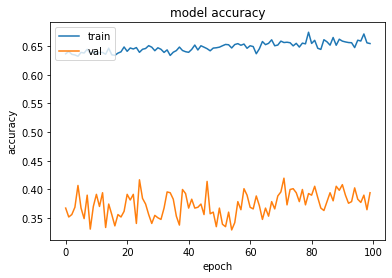

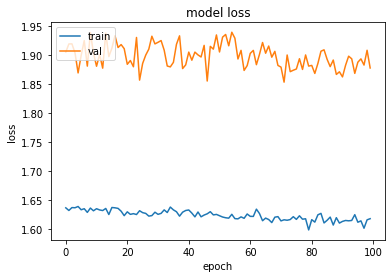

23/23 - 0s - loss: 1.8563 - accuracy: 0.4217


Accuracy( male_Age_Prediction ) on Test images ==>  42.17207431793213 % 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Exact 1-off Accuracy( male_Age_Prediction ) on Test images ==>  79.97179125528913 % 



In [ ]:
chain('male')

In [ ]:
chain('female')

Streaming output truncated to the last 5000 lines.
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.5.9257477006_17b21fd387_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.1.10165702624_edc43b7d6f_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.7.9563669899_07a118858d_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.1.10399404074_da554f9eb6_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.5.10346713835_752b765e40_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.5.11189001964_6013792f59_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.5.10438192163_99313949af_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.5.11562657043_7453f64f0c_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.5.11518818046_2c8153a1a2_o.jpg  
  inflating: female/train_data/25-32/coarse_tilt_aligned_face.5.11562643386_f3c985f1a5_o.jpg  
 

=======> child
child.zip                              male/
female/                                male_Age_Prediction_weights.best.h5
female_Age_Prediction_weights.best.h5  male.zip
female.zip                             sample_data/
Archive:  child.zip
   creating: child/
   creating: child/train_data/
   creating: child/train_data/0-2/
  inflating: child/train_data/0-2/coarse_tilt_aligned_face.186.10211585463_7258e6f135_o.jpg  
  inflating: child/train_data/0-2/coarse_tilt_aligned_face.186.10163401925_8de461d88c_o.jpg  
  inflating: child/train_data/0-2/coarse_tilt_aligned_face.186.10230569703_7b328fd649_o.jpg  
  inflating: child/train_data/0-2/coarse_tilt_aligned_face.186.10352348895_b3d416c45e_o.jpg  
  inflating: child/train_data/0-2/coarse_tilt_aligned_face.186.10211556343_78e40ec5e7_o.jpg  
  inflating: child/train_data/0-2/coarse_tilt_aligned_face.186.11417576495_3c3e3e2b6b_o.jpg  
  inflating: child/train_data/0-2/coarse_tilt_aligned_face.186.9083467706_9a11692a04_o.jpg  
  

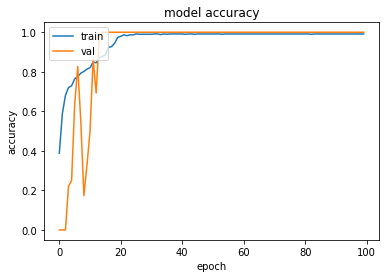

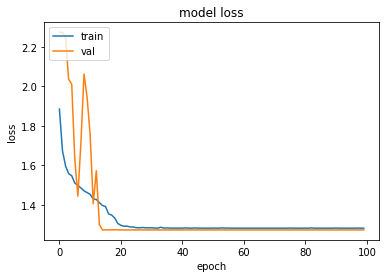

4/4 - 0s - loss: 1.2982 - accuracy: 0.9808


Accuracy( child_Age_Prediction ) on Test images ==>  98.07692170143127 % 



Exact 1-off Accuracy( child_Age_Prediction ) on Test images ==>  98.07692307692307 % 



In [ ]:
chain('child')